# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

## A probar: PERCEPTRON - LOGISTIC REGRESSION - SVM -

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve

## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"C:\Users\Pier\Documents\GitHub\Heart-Failure-ML\DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [3]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking","creatinine_phosphokinase","platelets"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

In [4]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [5]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

In [38]:
scaler.var_ # ESTA VARIANZA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

array([132.43331992, 146.84548121,   1.36863451,  16.30284258])

In [37]:
scaler.mean_ # ESTA MEDIA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

array([ 60.88656545,  37.91099476,   1.45020942, 136.72774869])

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

# LOGISTIC REGRESSION

In [45]:
hyperparam = {"poly__degree":[n for n in range(1,7)],"regressor__tol":[n for n in np.logspace(-2.0,-7.0, num=10)]}

lr_model = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["regressor",LogisticRegression(fit_intercept=False, tol=0.0000001, penalty="l2",max_iter=5000)]])

grilla = GridSearchCV(lr_model,hyperparam,cv=100,scoring="f1",n_jobs=-1)

grilla.fit(feat_train,targ_train)

C:\Users\Pier\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 62 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=100,
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['regressor',
                                        LogisticRegression(fit_intercept=False,
                                                           max_iter=5000,
                                                           tol=1e-07)]]),
             n_jobs=-1,
             param_grid={'poly__degree': [1, 2, 3, 4, 5, 6],
                         'regressor__tol': [0.01, 0.0027825594022071257,
                                            0.000774263682681127,
                                            0.00021544346900318823,
                                            5.994842503189409e-05,
                                            1.6681005372000593e-05,
                                            4.641588833612773e-06,
                                            1.2915496650148827e-06,
                                            3.59381366380

In [71]:
lr_model = grilla.best_estimator_

In [72]:
print(grilla.best_params_)
print(grilla.best_score_)
print(accuracy_score(targ_train, lr_model.predict(feat_train)))

{'poly__degree': 2, 'regressor__tol': 0.01}
0.29333333333333333
0.7643979057591623


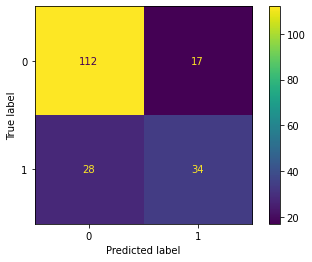

In [73]:
cm = confusion_matrix(targ_train, lr_model.predict(feat_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

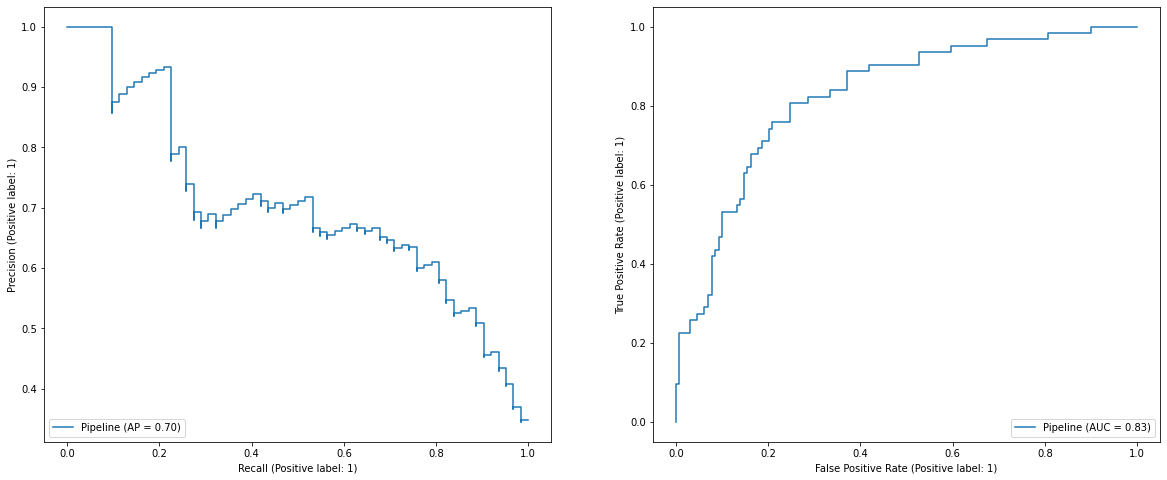

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(lr_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(lr_model, feat_train, targ_train,ax=ax2)

---

# SUPPORT VECTOR MACHINES

In [111]:
hyperparam = {"poly__degree":[n for n in range(1,10)],"SVC__C":[n for n in np.logspace(-4.0,4.0, num=10)]}

svml_model = Pipeline([["poly",PolynomialFeatures(degree=1,include_bias=True)],["SVC",LinearSVC(loss='hinge', C=1.0, fit_intercept=False, penalty='l2', max_iter=5000)]])

grilla = GridSearchCV(svml_model,hyperparam,cv=100,scoring="f1",n_jobs=-1)

grilla.fit(feat_train,targ_train)

C:\Users\Pier\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 62 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Pier\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=100,
             estimator=Pipeline(steps=[['poly', PolynomialFeatures(degree=1)],
                                       ['SVC',
                                        LinearSVC(fit_intercept=False,
                                                  loss='hinge',
                                                  max_iter=5000)]]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.0001, 0.000774263682681127,
                                    0.005994842503189409, 0.046415888336127774,
                                    0.3593813663804626, 2.782559402207126,
                                    21.54434690031882, 166.81005372000558,
                                    1291.5496650148827, 10000.0],
                         'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='f1')

In [112]:
svml_model = grilla.best_estimator_
print(grilla.best_params_)
print(grilla.best_score_)
print(accuracy_score(targ_train, lr_model.predict(feat_train)))

{'SVC__C': 0.0001, 'poly__degree': 9}
0.33
0.7643979057591623


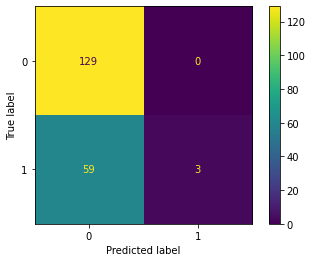

In [113]:
cm = confusion_matrix(targ_train, svml_model.predict(feat_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

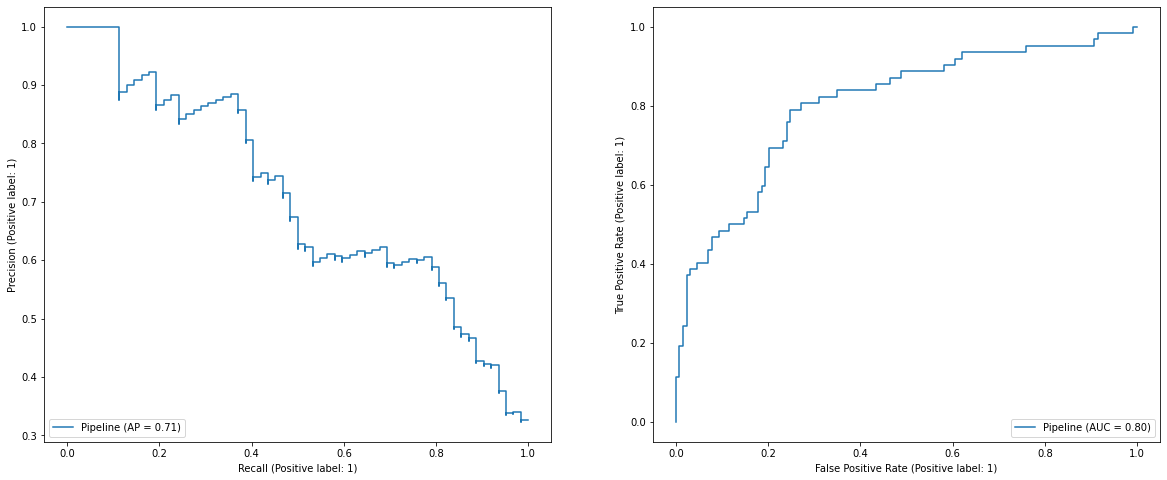

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svml_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svml_model, feat_train, targ_train,ax=ax2)

In [6]:
hyperparam = {"SVC__C":[n for n in np.logspace(0.0,3.0, num=2)],"SVC__gamma":[n for n in np.logspace(1.0,-5.0, num=2)],"SVC__degree":[n for n in range(1,2)]}

svm_model = Pipeline([["SVC",SVC(kernel='poly', degree=1.0, C=100.0, gamma=0.01)]])

grilla = GridSearchCV(svm_model,hyperparam,cv=100,scoring="f1")

grilla.fit(feat_train,targ_train)

C:\Users\Pier\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 61 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"


In [14]:
svm_model = grilla.best_estimator_
print(grilla.best_params_)
print(grilla.best_score_)
print(accuracy_score(targ_train, svm_model.predict(feat_train)))

{'SVC__C': 100.0, 'SVC__degree': 1, 'SVC__gamma': 0.001}
0.14
0.7801047120418848


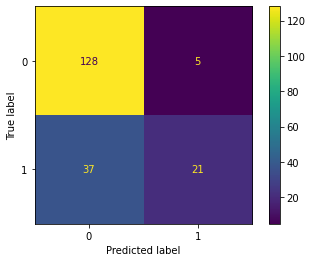

In [9]:
cm = confusion_matrix(targ_train, svm_model.predict(feat_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

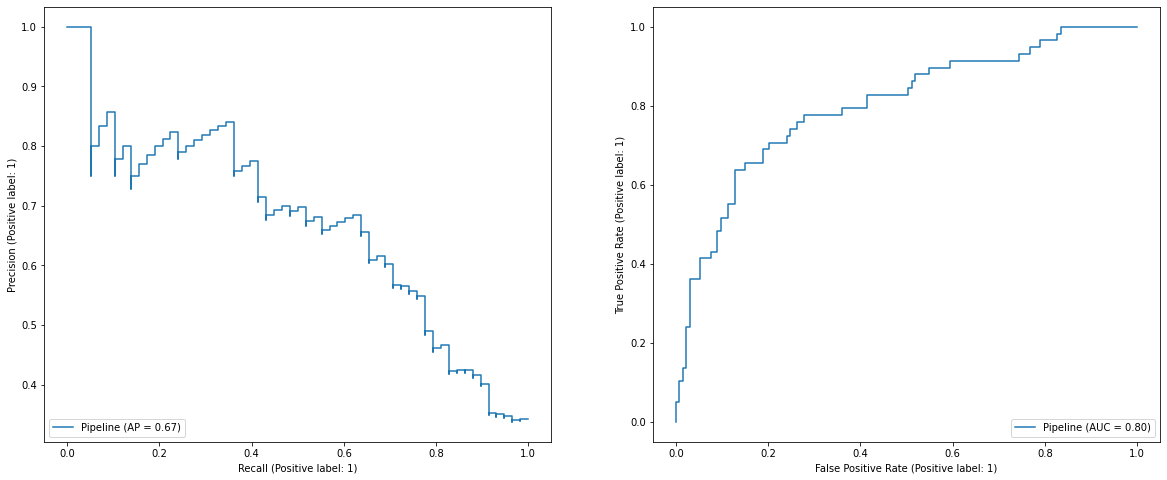

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot_precision_recall_curve(svm_model, feat_train, targ_train,ax=ax1)
plot_roc_curve(svm_model, feat_train, targ_train,ax=ax2)